# Effect of Phosphorylation on Transcription Factors in *Mycobacterium tuberculosis*

In [1]:
# Core Library Imports
import os
import json
import warnings

# External Library Imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import optuna
import pandas as pd
import seaborn as sb
import sklearn.model_selection
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.metrics import roc_auc_score

# Local Imports
import mycokinaseseq.kinase_tf_model
import mycokinaseseq.utils
import mycokinaseseq.list_helper as lh

In [2]:
# Global variables to determine some features of running this notebook
OPT_HYPERPARAMETERS = False

## Create Target Dictionaries
The first step is to create dictionaries which represent which TFs, and Kinases target which genes

In [3]:
# Read in the Transcription Factor Overexpression Data
# noinspection PyTypeChecker
tfoe_df = pd.read_excel(os.path.join("..","data", "tfoe.searchable_130115.xlsx"), sheet_name="TFOE.data",
                        header=0, usecols="A:HB", skiprows=9, index_col=0,
                        nrows=(4035-9))
# Rename the index column to be "gene"
tfoe_df.rename_axis('gene', inplace=True)
# Find the transcription factor targets
tf_targets_dict = {}
for tf in  tfoe_df.columns:
    tf_targets_dict[tf] = list(tfoe_df[np.abs(tfoe_df[tf] > 1)][tf].index)

In [4]:
# Create a dictionary for converting Pkn.. to Rv..
kinase_locus_dict = {
    "PknA": "Rv0015c",
    "PknB": "Rv0014c",
    "PknD": "Rv0931c",
    "PknE": "Rv1743",
    "PknF": "Rv1746",
    "PknG": "Rv0410c",
    "PknH": "Rv1266c",
    "PknI": "Rv2914c",
    "PknJ": "Rv2088",
    "PknK": "Rv3080c",
    "PknL": "Rv2176"
}

# Create a dictionary for converting Rv.. to Pkn..
locus_kinase_dict = {v:k for k,v in kinase_locus_dict.items()}

# Create target information from the overexpression data
# Read in the Kinase DF containing overexpression data
in_file = os.path.join("..","data","kinase_psites.xlsx")
kinase_targets_dict = {}
for kinase in ["B","D","E","F","G","H","I","J","K","L"]:
    df = pd.read_excel(in_file, sheet_name=f"Pkn{kinase}", header=0)
    df.rename(columns={"Rv Number":"gene"}, inplace=True)
    kinase_targets_dict[f"Pkn{kinase}"] = lh.get_unique_list(list(df["gene"]))

## Store Target Dictionaries
Now that the target dictionaries have been created, they can be stored as json files

In [5]:
# Save the TF dict
with open(os.path.join("..", "data", "dictionaries", "tf_targets_dict.json"), "w") as f:
    json.dump(tf_targets_dict, f)
# Save the kinase dict
with open(os.path.join("..","data","dictionaries","kinase_targets_dict.json"), "w") as f:
    json.dump(kinase_targets_dict, f)
# Save the kinase locus tag dictionaries as well
with open(os.path.join("..", "data", "dictionaries", "kinase_locus_dict.json"), "w") as f:
    json.dump(kinase_locus_dict, f)
with open(os.path.join("..","data","dictionaries", "locus_kinase_dict.json"), "w") as f:
    json.dump(locus_kinase_dict, f)

## Data Preprocessing
Now that the target information has been gathered, the compendia, and differential kinase expression RNA seq data can be processed

In [6]:
# Read in the RNA seq compendia for fitting the regression model
rna_seq_compendia = pd.read_csv(os.path.join("..","data","log_tpm.csv"), header=0, index_col=0).transpose()
# Read in the raw counts for the RNA seq compendia
rna_seq_raw = pd.read_csv(os.path.join("..","data","counts.csv"), header=0, index_col=0).transpose().loc[rna_seq_compendia.index, rna_seq_compendia.columns]
# Read in the sample information
sample_information = pd.read_csv(os.path.join("..","data","sample_table.csv"), header=0, index_col=0)
# Read in the RNA seq data from the OD and KD experiments
kinase_rna_seq = pd.read_csv(os.path.join("..","data", "kinase_rna_seq.csv"), header=0, index_col=0).drop("GrowthPhase", axis=1)

First, the RNA seq compendia needs to have genes where there are more than 10% of samples with low reads, and samples where there are more than 25% low reads. The bound for "low reads" will be determined by examining the histogram of the count data, and finding where the low peak is.

Text(0.5, 1.0, 'Density of Counts')

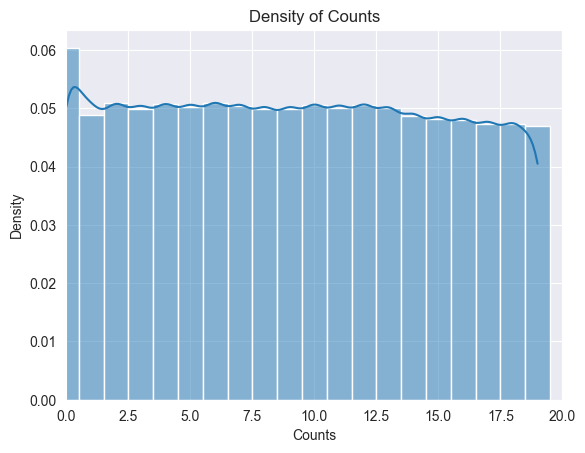

In [7]:
ul = 20
flattened_rna_seq_raw = rna_seq_raw.to_numpy().flatten()
filtered_rna_seq_raw = flattened_rna_seq_raw[flattened_rna_seq_raw < ul]

fig = plt.figure()
ax = plt.axes()
sb.histplot(filtered_rna_seq_raw, ax=ax, kde=True, stat="density", binwidth=1, discrete=True)
ax.set_xlim((0,ul))
ax.set_xlabel("Counts")
ax.set_title("Density of Counts")

In [8]:
# Based on the above histogram, a lower bound of 3 reads was chosen.
gene_lower_bound_counts = 3
gene_small_proportion = 0.1
sample_lower_bound_counts = 3
sample_small_proportion = 0.25

# Start by removing the samples where more than sample_small_proportion are less than sample_lower_bound_counts
small_count_samples = (rna_seq_raw<=gene_lower_bound_counts).mean(axis=1)
small_count_samples = small_count_samples[small_count_samples>sample_small_proportion].index
updated_rna_seq_raw = rna_seq_raw.drop(small_count_samples, axis=0)

# Next, remove genes where more than gene_small_proportion are less than gene_lower_bound_counts
small_count_genes = (rna_seq_raw<=gene_lower_bound_counts).mean(axis=0)
small_count_genes = small_count_genes[small_count_genes>gene_small_proportion].index
updated_rna_seq_raw = updated_rna_seq_raw.drop(small_count_genes, axis=1)

# Update the gene compendia to only include those genes and samples with sufficiently high reads
filtered_rna_compendia = rna_seq_compendia.loc[updated_rna_seq_raw.index, updated_rna_seq_raw.columns]

The reference conditions are also still included in the rna_compendia, and those will need to be removed

In [9]:
# Create dictionaries to hold information about which samples are in which project, and what the reference conditions for that project are
project_to_samples = {}
samples_to_project = {}
project_to_reference = {}
project_to_reference_samples ={}
reference_samples = []
# Go through each project and fill the dictionaries with the information
for project, df in sample_information.groupby("project"):
    # Get the name of the reference condition
    ref_condition = df["reference_condition"].values[0]
    # Check if all reference conditions are the same (they should be)
    if not (df["reference_condition"] == ref_condition).all():
        print(f"Project {project} has more than 1 reference condition")
        break
    # Add information to the dictionaries
    project_to_reference[project]=ref_condition
    project_to_samples[project] = list(df.index)
    for sample in df.index:
        samples_to_project[sample]=project
    # Find all the reference condition samples
    references = df[df["condition"]==ref_condition]
    project_to_reference_samples[project]=list(references.index)
    reference_samples+=list(references.index)

In [10]:
# Now, remove the reference samples from the filtered compendia
samples_to_remove = lh.find_intersect(list(filtered_rna_compendia.index), reference_samples)
filtered_rna_compendia = filtered_rna_compendia.drop(samples_to_remove, axis=0)

The kinase experiment data are in the form of RPKM, and must be converted to TPM, and then log2(fold-change) form

In [11]:
# Convert the RPKM to TPM using formula from Zhao et al., 2020 RNA
kinase_rna_seq = mycokinaseseq.utils.rpkm_to_tpm(kinase_rna_seq)
# Now this must be converted to log2(fold-change) form
# The reference conditions are all the wild-type samples
reference_list = list(map(lambda x: "WT" in x, kinase_rna_seq.index))
not_reference_list = [not x for x in reference_list]
reference_condition_average = kinase_rna_seq.loc[reference_list].mean(axis=1)
# Take the log2 transform of the fold change data
# Catching the divide by 0 error, and changing the inf it generates to a NaN
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    kinase_rna_compendia = np.log2(
        kinase_rna_seq.loc[not_reference_list].div(reference_condition_average,axis=1)
    ).replace([np.inf, -np.inf], np.nan)

In [12]:
# Find the set of genes shared by both datasets, and remove genes that are not found in both
shared_genes = lh.find_intersect(list(filtered_rna_compendia.columns), list(kinase_rna_compendia.columns))
filtered_rna_compendia = filtered_rna_compendia[shared_genes]
kinase_rna_compendia = kinase_rna_compendia[shared_genes]

## Split Data into a Development set, and a testing set

In [13]:
dev, test = sklearn.model_selection.train_test_split(filtered_rna_compendia, test_size=0.1, random_state=42)

## Hyperparameter Optimization for Elastic Net Regression

In [14]:
# Convert the kinase targets dict to be by locus tag instead of kinase name
kinase_dict = {}
for key, item in kinase_targets_dict.items():
    kinase_dict[kinase_locus_dict[key]] = item
# Create the regression object
model = mycokinaseseq.kinase_tf_model.KinaseTfModel(kinase_dict=kinase_dict, tf_dict=tf_targets_dict, gene_list=list(dev.columns))

# Create lists for splitting the dataframes into kinase, tf, and other gene expression
kinase_list = list(model.kinase_dict.keys())
tf_list = list(model.tf_dict.keys())
targeted_gene_list = model.targeted_genes

In [15]:
# Create the objective for the optuna Tree Parzen Estimator
def objective_cv(trial):
    # Define hyperparameter space
    alpha = trial.suggest_float("alpha",0.0,2.0)
    # For the L1_wt, it is suggested in sklearn to use more values closer to 1 to test with,
    # in order to do this, a categorical will be used with predefined values
    L1_wt = trial.suggest_float("L1_wt",0.0,1.0)

    # If the model is to be regularized, construct a kwarg dictionary
    kwarg_dict = {"alpha":alpha, "L1_wt":L1_wt}

    # Generate the cross validation iterator
    kfold = sklearn.model_selection.KFold(n_splits=5)

    # Separate out the dev set based on the kfold
    score_list = []
    for i, (train_index, test_index) in enumerate(kfold.split(dev)):
        model.fit(dev.iloc[train_index],significance_level=0.05,
                  multi_comparison_method="bh", false_discovery_rate=0.05,
                  regularized=True, verbose=True,
                  **kwarg_dict)
        # Add the score for each fold to the list
        score_list.append(
            model.score(kinase_expression=dev.iloc[test_index][kinase_list],
                        tf_expression=dev.iloc[test_index][tf_list],
                        gene_expression=dev.iloc[test_index][targeted_gene_list],
                        metric=sklearn.metrics.mean_squared_error).mean())
    score = np.mean(score_list)
    return score



def objective_single(trial):
    # Define hyperparameter space
    alpha = trial.suggest_float("alpha", 0.0,2.0)
    L1_wt = trial.suggest_float("L1_wt", 0.0,1.0)

    # Split the data to perform the scoring
    dev_train, dev_test = sklearn.model_selection.train_test_split(dev,test_size=0.2)

    # If the model is to be regularized, construct a kwarg dictionary
    kwarg_dict = {"alpha":alpha, "L1_wt":L1_wt}
    model.fit(dev_train,significance_level=0.05,
              multi_comparison_method="bh", false_discovery_rate=0.05,
              regularized=True, **kwarg_dict)
    return model.score(kinase_expression=dev_test[kinase_list],
                tf_expression=dev_test[tf_list],
                gene_expression=dev_test[targeted_gene_list],
                metric=sklearn.metrics.mean_squared_error).mean()

In [16]:
# If OPT_HYPERPARAMETERS is True, then run the optuna study, otherwise read the pre-generated values
if OPT_HYPERPARAMETERS:
    # Create the optuna study to find the optimum hyperparameters
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(n_startup_trials=10, multivariate=True), direction="minimize")
    study.optimize(objective_cv, n_trials=100)
    # Get the results as a dataframe
    results = study.trials_dataframe()
else:
    with open(os.path.join(".", "optimum_hyperparamters.json"),"r") as f:
        hyperparameters_dict = json.load(f)

In [17]:
if not OPT_HYPERPARAMETERS:
    results = pd.read_csv(os.path.join(".","results.csv"))

Text(0.5, 0, 'alpha')

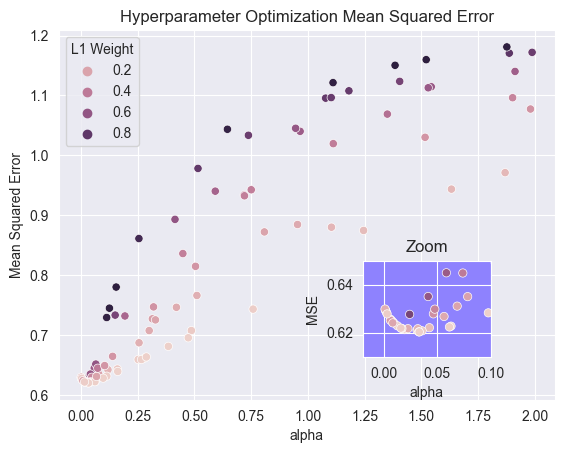

In [18]:
fig, ax = plt.subplots()
sb.scatterplot(data=results, x="params_alpha", y="value", hue="params_L1_wt", ax=ax)
ax.set_ylabel("Mean Squared Error")
ax.set_xlabel("alpha")
ax.legend(title="L1 Weight")
ax.set_title("Hyperparameter Optimization Mean Squared Error")

ax2 = plt.axes([0.6, 0.2, 0.2, 0.2], facecolor = "xkcd:periwinkle")
sb.scatterplot(data=results, x="params_alpha", y="value", hue="params_L1_wt", ax=ax2, legend=False)
ax2.set_title("Zoom")
ax2.set_xlim(-0.02,0.1)
ax2.set_ylim(0.61,0.65)
ax2.set_ylabel("MSE")
ax2.set_xlabel("alpha")

In [19]:
if OPT_HYPERPARAMETERS:
    opt_alpha = results.sort_values(by="value")["params_alpha"].iloc[0]
    opt_L1_wt = results.sort_values(by="value")["params_L1_wt"].iloc[0]
    print(f"The optimum value for the parameters found by the Tree Parzen estimator are:\n"
          f"alpha: {opt_alpha}\n"
          f"L1_wt: {opt_L1_wt}\n")
    # Save the optimum hyperparameters to avoid rerunning the hyperparameter optimization
    with open(os.path.join(".","optimum_hyperparamters.json",),"w") as f:
        json.dump({"opt_alpha":opt_alpha, "opt_L1_wt":opt_L1_wt}, f)
    # Save the results dataframe
    results.to_csv(os.path.join(".","results.csv"))
else:
    opt_alpha = hyperparameters_dict["opt_alpha"]
    opt_L1_wt = hyperparameters_dict["opt_L1_wt"]

## Dev set testing

In [20]:
# Set up variable for verbose output
VERBOSE = True

# Check if directory for this exists, and if not create it
cv_directory = os.path.join("..","data","cross_validation")
if not os.path.exists(cv_directory):
    os.mkdir(cv_directory)
#dev set testing
cv_splits = 5
kfold = sklearn.model_selection.KFold(n_splits=cv_splits)

# Create the restricted model objects
tf_only_model = mycokinaseseq.kinase_tf_model.TfOnlyModel(kinase_dict=kinase_dict, tf_dict=tf_targets_dict, gene_list=list(dev.columns))
tf_kinase_restricted_model = mycokinaseseq.kinase_tf_model.TfKinaseRestrictedModel(kinase_dict=kinase_dict, tf_dict=tf_targets_dict, gene_list=list(dev.columns))
tf_kinase_full_model = mycokinaseseq.kinase_tf_model.TfKinaseFullModel(kinase_dict=kinase_dict, tf_dict=tf_targets_dict, gene_list=list(dev.columns))


# Set up dicts to hold lists of scores
# Regression metrics
mse_scores = {"tf_only":[], "tf_kinase_restricted":[], "tf_kinase_full":[], "significant_model":[], "overall":[]}
mae_scores = {"tf_only":[], "tf_kinase_restricted":[], "tf_kinase_full":[], "significant_model":[], "overall":[]}
median_ae_scores = {"tf_only":[], "tf_kinase_restricted":[], "tf_kinase_full":[], "significant_model":[], "overall":[]}
r2_scores = {"tf_only":[], "tf_kinase_restricted":[], "tf_kinase_full":[], "significant_model":[], "overall":[]}

# Decision function classification metrics
roc_auc_scores = {"significant_model":[], "overall":[]}

# Label based classification metrics
accuracy_scores = {"significant_model":[], "overall":[]}
precision_scores = {"significant_model":[], "overall":[]}
recall_scores = {"significant_model":[], "overall":[]}
f_scores = {"significant_model":[], "overall":[]}
balanced_accuracy_scores = {"significant_model":[], "overall":[]}

for index, (train_index, test_index) in enumerate(kfold.split(dev)):
    # Fit the model objects
    if VERBOSE:
        print("Fitting Significant Associations model")
    model.fit(dev.iloc[train_index],
              significance_level=0.05,
              multi_comparison_method="bh",
              false_discovery_rate=0.05,
              verbose=VERBOSE,
              regularized=True,
              intercept=True,
              alpha=opt_alpha,
              L1_wt = opt_L1_wt)
    if VERBOSE:
        print("Fitting TF only model")
    tf_only_model.fit(dev.iloc[train_index], regularized=True, intercept=True, alpha=opt_alpha, L1_wt = opt_L1_wt, verbose=VERBOSE)
    if VERBOSE:
        print("Fitting TF Kinase restricted model")
    tf_kinase_restricted_model.fit(dev.iloc[train_index], regularized=True, intercept=True, alpha=opt_alpha, L1_wt=opt_L1_wt, verbose=VERBOSE)
    if VERBOSE:
        print("Fitting TF Kinase Full Model")
    tf_kinase_full_model.fit(dev.iloc[train_index], regularized=True, intercept=True, alpha=opt_alpha, L1_wt=opt_L1_wt, verbose=VERBOSE)

    # Score by gene regression
    # Mean squared error
    mse_scores["significant_model"].append(model.score_gene_regression(kinase_expression=dev.iloc[test_index][kinase_list],
                                                                       tf_expression=dev.iloc[test_index][tf_list],
                                                                       gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                       metric=mean_squared_error))
    mse_scores["tf_only"].append(tf_only_model.score(tf_expression=dev.iloc[test_index][tf_list],
                                                     gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                     metric=mean_squared_error))
    mse_scores["tf_kinase_restricted"].append(tf_kinase_restricted_model.score(tf_expression=dev.iloc[test_index][tf_list],
                                                                               kinase_expression=dev.iloc[test_index][kinase_list],
                                                                               gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                               metric=mean_squared_error))
    mse_scores["tf_kinase_full"].append(tf_kinase_full_model.score(tf_expression=dev.iloc[test_index][tf_list],
                                                                   kinase_expression=dev.iloc[test_index][kinase_list],
                                                                   gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                   metric=mean_squared_error))
    mse_scores["overall"].append(model.score_overall_regression(kinase_expression=dev.iloc[kinase_list][kinase_list],
                                                                tf_expression=dev.iloc[test_index][tf_list],
                                                                gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                metric=mean_squared_error))
    # Mean Absolute Error
    mae_scores["significant_model"].append(model.score_gene_regression(kinase_expression=dev.iloc[test_index][kinase_list],
                                                                       tf_expression=dev.iloc[test_index][tf_list],
                                                                       gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                       metric=mean_absolute_error))
    mae_scores["tf_only"].append(tf_only_model.score(tf_expression=dev.iloc[test_index][tf_list],
                                                     gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                     metric=mean_absolute_error))
    mae_scores["tf_kinase_restricted"].append(tf_kinase_restricted_model.score(tf_expression=dev.iloc[test_index][tf_list],
                                                                               kinase_expression=dev.iloc[test_index][kinase_list],
                                                                               gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                               metric=mean_absolute_error))
    mae_scores["tf_kinase_full"].append(tf_kinase_full_model.score(tf_expression=dev.iloc[test_index][tf_list],
                                                                   kinase_expression=dev.iloc[test_index][kinase_list],
                                                                   gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                   metric=mean_absolute_error))
    mae_scores["overall"].append(model.score_overall_regression(kinase_expression=dev.iloc[kinase_list][kinase_list],
                                                                tf_expression=dev.iloc[test_index][tf_list],
                                                                gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                metric=mean_absolute_error))
    # Median Absolute Error
    median_ae_scores["significant_model"].append(model.score_gene_regression(kinase_expression=dev.iloc[test_index][kinase_list],
                                                                       tf_expression=dev.iloc[test_index][tf_list],
                                                                       gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                       metric=median_absolute_error))
    median_ae_scores["tf_only"].append(tf_only_model.score(tf_expression=dev.iloc[test_index][tf_list],
                                                     gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                     metric=median_absolute_error))
    median_ae_scores["tf_kinase_restricted"].append(tf_kinase_restricted_model.score(tf_expression=dev.iloc[test_index][tf_list],
                                                                               kinase_expression=dev.iloc[test_index][kinase_list],
                                                                               gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                               metric=median_absolute_error))
    median_ae_scores["tf_kinase_full"].append(tf_kinase_full_model.score(tf_expression=dev.iloc[test_index][tf_list],
                                                                   kinase_expression=dev.iloc[test_index][kinase_list],
                                                                   gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                   metric=median_absolute_error))
    median_ae_scores["overall"].append(model.score_overall_regression(kinase_expression=dev.iloc[kinase_list][kinase_list],
                                                                tf_expression=dev.iloc[test_index][tf_list],
                                                                gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                metric=median_absolute_error))
    # R2 scores
    r2_scores["significant_model"].append(model.score_gene_regression(kinase_expression=dev.iloc[test_index][kinase_list],
                                                                       tf_expression=dev.iloc[test_index][tf_list],
                                                                       gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                       metric=r2_score))
    r2_scores["tf_only"].append(tf_only_model.score(tf_expression=dev.iloc[test_index][tf_list],
                                                     gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                     metric=r2_score))
    r2_scores["tf_kinase_restricted"].append(tf_kinase_restricted_model.score(tf_expression=dev.iloc[test_index][tf_list],
                                                                               kinase_expression=dev.iloc[test_index][kinase_list],
                                                                               gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                               metric=r2_score))
    r2_scores["tf_kinase_full"].append(tf_kinase_full_model.score(tf_expression=dev.iloc[test_index][tf_list],
                                                                   kinase_expression=dev.iloc[test_index][kinase_list],
                                                                   gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                   metric=r2_score))
    r2_scores["overall"].append(model.score_overall_regression(kinase_expression=dev.iloc[kinase_list][kinase_list],
                                                                tf_expression=dev.iloc[test_index][tf_list],
                                                                gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                metric=r2_score))

    # ROC AUC Score
    roc_auc_scores["significant_model"].append(model.score_gene_classification_decision_function(kinase_expression=dev.iloc[test_index][kinase_list],
                                                                                                 tf_expression=dev.iloc[test_index][tf_list],
                                                                                                 gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                                                 metric=roc_auc_score))
    roc_auc_scores["overall"].append(model.score_overall_classification_decision_function(kinase_expression=dev.iloc[test_index][kinase_list],
                                                                                          tf_expression=dev.iloc[test_index][tf_list],
                                                                                          gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                                          metric=roc_auc_score))

    # Classification Label Scores
    # Accuracy
    accuracy_scores["significant_model"].append(model.score_gene_classification_labels(kinase_expression=dev.iloc[test_index][kinase_list],
                                                                                       tf_expression=dev.iloc[test_index][tf_list],
                                                                                       gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                                       metric=accuracy_score))
    accuracy_scores["overall"].append(model.score_overall_classification_labels(kinase_expression=dev.iloc[test_index][kinase_list],
                                                                                tf_expression=dev.iloc[test_index][tf_list],
                                                                                gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                                metric=accuracy_score))
    # Precision
    precision_scores["significant_model"].append(model.score_gene_classification_labels(kinase_expression=dev.iloc[test_index][kinase_list],
                                                                                       tf_expression=dev.iloc[test_index][tf_list],
                                                                                       gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                                       metric=precision_score))
    precision_scores["overall"].append(model.score_overall_classification_labels(kinase_expression=dev.iloc[test_index][kinase_list],
                                                                                tf_expression=dev.iloc[test_index][tf_list],
                                                                                gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                                metric=precision_score))
    # f1 scores
    f_scores["significant_model"].append(model.score_gene_classification_labels(kinase_expression=dev.iloc[test_index][kinase_list],
                                                                                       tf_expression=dev.iloc[test_index][tf_list],
                                                                                       gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                                       metric=f1_score))
    f_scores["overall"].append(model.score_overall_classification_labels(kinase_expression=dev.iloc[test_index][kinase_list],
                                                                                tf_expression=dev.iloc[test_index][tf_list],
                                                                                gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                                metric=f1_score))
    # Balanced Accuracy Scores
    balanced_accuracy_scores["significant_model"].append(model.score_gene_classification_labels(kinase_expression=dev.iloc[test_index][kinase_list],
                                                                                       tf_expression=dev.iloc[test_index][tf_list],
                                                                                       gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                                       metric=balanced_accuracy_score))
    balanced_accuracy_scores["overall"].append(model.score_overall_classification_labels(kinase_expression=dev.iloc[test_index][kinase_list],
                                                                                tf_expression=dev.iloc[test_index][tf_list],
                                                                                gene_expression=dev.iloc[test_index][targeted_gene_list],
                                                                                metric=balanced_accuracy_score))

Fitting Significant Associations model
Finding Significant Associations
■■■■■■■■■■100.00%
Finished!
Found Associations
Finding Model Coefficients
■■■■■■■■■■100.00%
Finished!
Found Coefficients
Fitting TF only model
Finding Coefficients
■■■■■■■■■■100.00%
Finished!
Found Coefficients
Fitting TF Kinase restricted model
Finding Model Coefficients
■■■■■■■■■■100.00%
Finished!
Found Coefficients
Fitting TF Kinase Full Model
Finding model coefficients
■■■■■■■■■■100.00%
Finished!
Found Coefficients


ValueError: Indices are not equal

In [ ]:
# Gather individual metrics, then create overall summaries
overall_scores = pd.DataFrame(0., columns=['mse','mae','medae', 'r2', 'auc_roc', 'accuracy', 'precision', 'recall', 'f1', 'balanced_accuracy'],
                              index=[f"cv_{i}" for i in range(cv_splits)])
# Rename the series so that concatenation is easier
for i in range(cv_splits):
    for metric_dict in [mse_scores, mae_scores, median_ae_scores, r2_scores]:
        # Rename the score series
        metric_dict["tf_only"][i].name= f"cv_{i}"
        metric_dict["tf_kinase_restricted"][i].name= f"cv_{i}"
        metric_dict["tf_kinase_full"][i].name= f"cv_{i}"
        metric_dict["significant_model"][i].name= f"cv_{i}"
        metric_dict["overall"][i].name= f"cv_{i}"
    # Rename the series for the roc_auc_scores
    roc_auc_scores["significant_model"][i].name = f"cv_{i}"
    # rename the series for classification metrics
    for metric_dict in [accuracy_scores, precision_scores, recall_scores, f_scores, balanced_accuracy_scores]:
        metric_dict["significant_model"].name = f"cv_{i}"
    # Add the values into the overall scores dict
    overall_scores.loc[f"cv_{i}", "mse"] = mse_scores["overall"][i]
    overall_scores.loc[f"cv_{i}", "mae"] = mae_scores["overall"][i]
    overall_scores.loc[f"cv_{i}", "medae"] = median_ae_scores["overall"][i]
    overall_scores.loc[f"cv_{i}", "r2"] = r2_scores["overall"][i]
    overall_scores.loc[f"cv_{i}", "auc_roc"] = roc_auc_scores["overall"][i]
    overall_scores.loc[f"cv_{i}", "accuracy"] = accuracy_scores["overall"][i]
    overall_scores.loc[f"cv_{i}", "precision"] = precision_scores["overall"][i]
    overall_scores.loc[f"cv_{i}", "recall"] = recall_scores["overall"][i]
    overall_scores.loc[f"cv_{i}", "f1"] = f_scores["overall"][i]
    overall_scores.loc[f"cv_{i}", "balanced_accuracy"] = balanced_accuracy_scores["overall"][i]
# Compute the mean and std dev of the metrics across the cross validations
overall_scores.loc["mean"] = overall_scores.mean(axis=0)
overall_scores.loc["std"] = overall_scores.std(axis=0)

# Concatenate the score series across the cross validations
for metric_dict in [mse_scores, mae_scores, median_ae_scores, r2_scores]:
    metric_dict["tf_only"]=pd.concat(metric_dict["tf_only"] , axis=1)
    metric_dict["tf_kinase_restricted"]=pd.concat(metric_dict["tf_kinase_restricted"] , axis=1)
    metric_dict["tf_kinase_full"]=pd.concat(metric_dict["tf_kinase_full"] , axis=1)
    metric_dict["significant_model"]=pd.concat(metric_dict["significant_model"] , axis=1)

# Concatenate the score series for the classification metrics
for metric_dict in [accuracy_scores, precision_scores, recall_scores, f_scores, balanced_accuracy_scores]:
    metric_dict = pd.concat(metric_dict["significant_model"], axis=1)

score_summary_dict = {
    # mse scores
    "tf_only_mse_mean":mse_scores["tf_only"].mean(axis=1),
    "tf_only_mse_std":mse_scores["tf_only"].std(axis=1),
    "tf_kinase_mse_mean":mse_scores["tf_kinase_restricted"].mean(axis=1),
    "tf_kinase_mse_std":mse_scores["tf_kinase_restricted"].std(axis=1),
    "tf_kinase_full_mse_mean":mse_scores["tf_kinase_full"].mean(axis=1),
    "tf_kinase_full_mse_std":mse_scores["tf_kinase_full"].std(axis=1),
    "significant_model_mse_mean":mse_scores["significant_model"].mean(axis=1),
    "significant_model_mse_std":mse_scores["significant_model"].std(axis=1),
    # mae scores
    "tf_only_mae_mean":mae_scores["tf_only"].mean(axis=1),
    "tf_only_mae_std":mae_scores["tf_only"].std(axis=1),
    "tf_kinase_mae_mean":mae_scores["tf_kinase_restricted"].mean(axis=1),
    "tf_kinase_mae_std":mae_scores["tf_kinase_restricted"].std(axis=1),
    "tf_kinase_full_mae_mean":mae_scores["tf_kinase_full"].mean(axis=1),
    "tf_kinase_full_mae_std":mae_scores["tf_kinase_full"].std(axis=1),
    "significant_model_mae_mean":mae_scores["significant_model"].mean(axis=1),
    "significant_model_mae_std":mae_scores["significant_model"].std(axis=1),
    # Median absolute error scores
    "tf_only_median_ae_mean":median_ae_scores["tf_only"].mean(axis=1),
    "tf_only_median_ae_std":median_ae_scores["tf_only"].std(axis=1),
    "tf_kinase_median_ae_mean":median_ae_scores["tf_kinase_restricted"].mean(axis=1),
    "tf_kinase_median_ae_std":median_ae_scores["tf_kinase_restricted"].std(axis=1),
    "tf_kinase_full_median_ae_mean":median_ae_scores["tf_kinase_full"].mean(axis=1),
    "tf_kinase_full_median_ae_std":median_ae_scores["tf_kinase_full"].std(axis=1),
    "significant_model_median_ae_mean":median_ae_scores["significant_model"].mean(axis=1),
    "significant_model_median_ae_std":median_ae_scores["significant_model"].std(axis=1),
    # R2 scores
    "tf_only_r2_mean":r2_scores["tf_only"].mean(axis=1),
    "tf_only_r2_std":r2_scores["tf_only"].std(axis=1),
    "tf_kinase_r2_mean":r2_scores["tf_kinase_restricted"].mean(axis=1),
    "tf_kinase_r2_std":r2_scores["tf_kinase_restricted"].std(axis=1),
    "tf_kinase_full_r2_mean":r2_scores["tf_kinase_full"].mean(axis=1),
    "tf_kinase_full_r2_std":r2_scores["tf_kinase_full"].std(axis=1),
    "significant_model_r2_mean":r2_scores["significant_model"].mean(axis=1),
    "significant_model_r2_std":r2_scores["significant_model"].std(axis=1),
    # Decision function classification metrics
    "significant_model_roc_auc_mean":roc_auc_scores["significant_model"].mean(axis=1),
    "significant_model_roc_auc_std":roc_auc_scores["significant_model"].std(axis=1),
    # Label classification metrics
    "significant_model_accuracy_mean":accuracy_scores["significant_model"].mean(axis=1),
    "significant_model_accuracy_std":accuracy_scores["significant_model"].std(axis=1),
    "significant_model_precision_mean":precision_scores["significant_model"].mean(axis=1),
    "significant_model_precision_std":precision_scores["significant_model"].std(axis=1),
    "significant_model_f1_mean":f_scores["significant_model"].mean(axis=1),
    "significant_model_f1_std":f_scores["significant_model"].std(axis=1),
    "significant_model_balanced_accuracy_mean":balanced_accuracy_scores["significant_model"].mean(axis=1),
    "significant_model_balanced_accuracy_std":balanced_accuracy_scores["significant_model"].std(axis=1),
}
score_summary_df = pd.DataFrame(score_summary_dict)
score_summary_df.to_csv(os.path.join(cv_directory, "score_summary.csv"))
overall_scores.to_csv(os.path.join(cv_directory, "overall_scores.csv"))

## Fit Model with Optimum Hyperparameters

In [ ]:
model.fit(dev, significance_level=0.05, multi_comparison_method="bh", false_discovery_rate=0.05,regularized=True,
          intercept=True,verbose=True, alpha = opt_alpha, L1_wt = opt_L1_wt)

## Combine associations from the Model with Essentiality information

In [ ]:
# Read in Essentiality Dataframe
# from Barbara Bosch, Michael A. DeJesus, Nicholas C. Poulton, Wenzhu Zhang, Curtis A. Engelhart, Anisha Zaveri, Sophie Lavalette,
# Nadine Ruecker, Carolina Trujillo, Joshua B. Wallach, Shuqi Li, Sabine Ehrt, Brian T. Chait, Dirk Schnappinger, Jeremy M. Rock,
# Genome-wide gene expression tuning reveals diverse vulnerabilities of M. tuberculosis, Cell, Volume 184, Issue 17, 2021,
# Pages 4579-4592.e24, ISSN 0092-8674, https://doi.org/10.1016/j.cell.2021.06.033. (https://www.sciencedirect.com/science/article/pii/S0092867421008242)
essentiality_df = pd.read_excel(os.path.join("..","data","Vulnerability_Index.xlsx"),
                             sheet_name="(1) Mtb H37Rv",
                             header=0)[["locus_tag","name","tnseq_ess","crispr_ess","Vulnerability Index"]]
 # Rename the locus tag to Rv.. form
essentiality_df["locus_tag"] = essentiality_df["locus_tag"].apply(lambda x: x.replace("RVBD","Rv"))
essentiality_df["name"] = essentiality_df["name"].apply(lambda x: x.replace("RVBD","Rv"))
# Rename locus_tag column to gene to match with associations dataframe
essentiality_df = essentiality_df.rename({"locus_tag":"gene"}, axis=1)
# Convert "gene" to be type string
essentiality_df["gene"] = essentiality_df["gene"].astype("string")

In [ ]:
# Get associations dataframe from the fitted model
associations_df = model.create_associations_information_df()
# Convert "gene" column to be of type string
associations_df["gene"] = associations_df["gene"].astype("string")
# Merge the associations with the essentiality information
associations_df = associations_df.merge(essentiality_df, on="gene",how="left")

In [ ]:
# Save the dataframe
associations_df.to_csv(os.path.join("..","output","associations.csv"))

## Analyze Model

In [ ]:
# score the model against the test set from the original compendia
test_set_scores = model.score_full(kinase_expression=test[kinase_list], tf_expression=test[tf_list], gene_expression=test[targeted_gene_list])
test_set_scores.to_csv(os.path.join("..","output","test_set_scores.csv"))
# score the model against the independent kinase seq data
kinase_seq_scores = model.score_full(kinase_expression=kinase_rna_seq[kinase_list],
                                     tf_expression=kinase_rna_seq[tf_list],
                                     gene_expression=kinase_rna_seq[targeted_gene_list])
kinase_seq_scores.to_csv(os.path.join("..","output","kinase_seq_scores.csv"))

## Visualizations

In [ ]:
essentiality_df = essentiality_df.set_index("gene")
network = model.create_network_from_associations(essentiality_df=essentiality_df, essentiality_col="crispr_ess")
with (os.path.join("..","data","output","associations_network.json"), "w") as f:
    json.dump(nx.node_link_data(network), f)
model.create_cytoscape_from_associations(essentiality_df=essentiality_df, essentiality_col="crispr_ess",
                                         outfile=os.path.join("..","data", "output","associations_network.cyjs"))